In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import datetime as dt

from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
import tensorflow_probability as tfp
from fit_one_cycle import OneCycleScheduler
from lr_finder import LRFinder

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


df_1T = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)
df_5T = pd.read_parquet('df_CNN_LSTM_5T.parquet')
df_15T = pd.read_parquet('df_CNN_LSTM_15T.parquet')
df_1H = pd.read_parquet('df_CNN_LSTM_1H.parquet')
df_4H = pd.read_parquet('df_CNN_LSTM_4H.parquet')
df_1B = pd.read_parquet('df_CNN_LSTM_1B.parquet').fillna(0)

# df_1T = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True).drop(columns=[c for c in df_1T if '_nq' in c])
# df_5T = pd.read_parquet('df_CNN_LSTM_5T.parquet').drop(columns=[c for c in df_5T if '_nq' in c])
# df_15T = pd.read_parquet('df_CNN_LSTM_15T.parquet').drop(columns=[c for c in df_15T if '_nq' in c])
# df_1H = pd.read_parquet('df_CNN_LSTM_1H.parquet').drop(columns=[c for c in df_1H if '_nq' in c])
# df_4H = pd.read_parquet('df_CNN_LSTM_4H.parquet').drop(columns=[c for c in df_4H if '_nq' in c])
# df_1B = pd.read_parquet('df_CNN_LSTM_1B.parquet').fillna(0).drop(columns=[c for c in df_1B if '_nq' in c])

In [90]:
# Define the data generator function
def normalize_and_yield(batch_data, batch_targets):
    # Convert to np.array
    batch_data = np.asarray(batch_data)
    batch_targets = np.asarray(batch_targets)
    
    # Normalize
    cols_to_standardize = ['open_es', 'high_es', 'low_es', 'close_es', 'open_nq', 'high_nq', 'low_nq', 'close_nq', 'weekly_open', 'weekly_close']
    cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]
    for i in range(batch_data.shape[1]):
        a = batch_data[:, i, :, [0, 1, 2, 3, 7, 8, 9, 10, 24, 25]]
        scaler = StandardScaler()
        batch_data[:, i, :, cols_to_standardize] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])

    batch_data = batch_data.astype('float32')
    batch_data = np.split(batch_data, 6, axis=1)
    batch_data = [element.squeeze(axis=1) for element in batch_data]

    return np.asarray(batch_data), batch_targets.astype('float32')


def data_generator(data, window_size, batch_size, indices):
    batch_data = []
    batch_targets = []
    i=0
    for index in indices:
        dt_index = df_1T.iloc[index].name
        input_sequences = np.array([
            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-window_size:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-window_size:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-window_size:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-window_size:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-window_size:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-window_size:].fillna(0).values.astype('float32')
        ])

        # Extract the target high and low values
        target_high = df_1T[index : index+151].high_es.max()
        target_low = df_1T[index : index+151].low_es.min()

        # Add the input sequence and targets to the batch
        batch_data.append(input_sequences)
        batch_targets.append([target_high, target_low])
        print(i, len(indices)) if i % 256 == 0 else None
        i += 1
        
    return normalize_and_yield(batch_data, batch_targets)


                
# Set the window size and batch size
window_size = 90 # minutes in 252 days (1 year of trading days)
batch_size = 64
num_features = df_1T.shape[1]-1

# set random seed for the shuffle function
np.random.seed(42)

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
data_indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > df_1T[df_1B[:window_size+1].iloc[-1].name:].iloc[0]['index'].astype(int))]['index'].to_numpy()
X, y = data_generator(df_1T, window_size, batch_size, data_indices)

# Get the total number of samples and calculate the split index
num_samples = X.shape[1]
train_ratio = 0.9
split_index = int(num_samples * train_ratio)

# Shuffle the indices
indices = np.arange(num_samples)#np.random.permutation(np.arange(num_samples))

# Split the array based on the shuffled indices
X_train = list(X[:, indices[:split_index], :, :])
y_train = y[indices[:split_index]]
X_test = list(X[:, indices[split_index:], :, :])
y_test = y[indices[split_index:]]

0 3627
256 3627
512 3627
768 3627
1024 3627
1280 3627
1536 3627
1792 3627
2048 3627
2304 3627
2560 3627
2816 3627
3072 3627
3328 3627
3584 3627


In [15]:
# # Reshape X_train to a 2D array
# X_train = np.asarray(X_train)
# orig_shape = X_train.shape

# # Fit the scaler to the data and transform X_train
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape((-1, X_train.shape[-1])))

# # Reshape X_train_scaled_2d back to the original shape
# X_train = list(X_train.reshape(orig_shape))

In [107]:
# Define the Transformer model

# Define the input layer
inputs_1T = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_5T = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_15T = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_1H = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_4H = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_1B = Input(shape=(window_size, num_features), batch_size=batch_size)

main_inputs = [inputs_1T, inputs_5T, inputs_15T, inputs_1H, inputs_4H, inputs_1B]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mse'], run_eagerly=False)

In [109]:
#model.summary()
#tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))(output1)

#### layer activations
#### tensorboard

Epoch 1/300


/Users/kush/Documents/DS/env/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))(output1)# Dense(1)(output1)

  config_arr = [serialize_keras_object(x) for x in obj]


91/91 [==============================] - 8s 72ms/step - loss: 339.3975 - mse: 507621.0312 - val_loss: 66.0895 - val_mse: 5878.9541
Epoch 2/300
 1/91 [..............................] - ETA: 4s - loss: 27.0116 - mse: 1281.0637

/Users/kush/Documents/DS/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 4s 42ms/step - loss: 26.6818 - mse: 1923.8375 - val_loss: 40.5814 - val_mse: 2537.8853
Epoch 3/300
91/91 [==============================] - 4s 39ms/step - loss: 32.0616 - mse: 2561.7158 - val_loss: 36.3897 - val_mse: 2137.3604
Epoch 4/300
91/91 [==============================] - 4s 39ms/step - loss: 29.8287 - mse: 2154.8955 - val_loss: 88.1846 - val_mse: 9404.5059
Epoch 5/300
91/91 [==============================] - 3s 38ms/step - loss: 31.3777 - mse: 2277.0793 - val_loss: 96.8785 - val_mse: 10972.3975
Epoch 6/300
91/91 [==============================] - 4s 40ms/step - loss: 23.3793 - mse: 1368.8282 - val_loss: 31.1245 - val_mse: 1662.5558
Epoch 7/300
91/91 [==============================] - 4s 39ms/step - loss: 20.0207 - mse: 1088.3396 - val_loss: 39.1437 - val_mse: 2175.8386
Epoch 8/300
91/91 [==============================] - 3s 37ms/step - loss: 24.4423 - mse: 1438.0593 - val_loss: 75.6079 - val_mse: 8541.3525
Epoch 9/300
91/91 [============

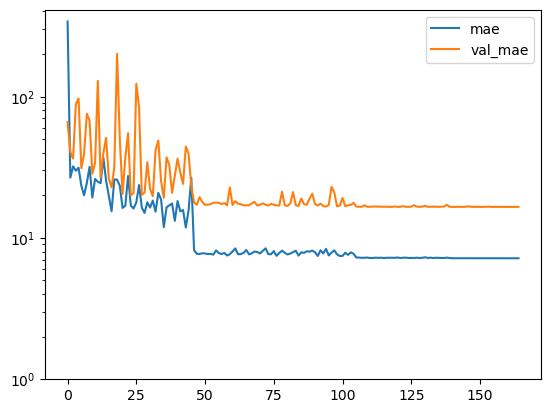

In [110]:
epochs = 300
lr = 1e-2

train_steps_per_epoch = len(X_train[0]) // batch_size

#lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)
lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)
lr_finder = LRFinder()

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10)


log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights based on the monitored metric
)

# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model_test.h5',  # Filepath to save the best model
    monitor='val_loss',  # Metric to monitor for saving the best model
    save_best_only=True  # Save only the best model based on the monitored metric
)

history = model.fit(X_train, y_train[:,1], epochs=epochs, validation_split=0.11111,
                    callbacks=[lr_schedule, early_stopping, tensorboard_callback, checkpoint])

# Plot the training and validation loss and MAE
plt.semilogy(history.history['loss'], label='mae')
plt.semilogy(history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 0
plt.legend()
plt.show()

In [113]:
y_pred = model.predict(X_test)

12/12 [==============================] - 1s 70ms/step


In [149]:
y_pred[4] - y_test[4][1]

array([-29.21875  , -19.44043  , -14.211914 , -20.171875 , -18.105469 ,
       -10.8359375, -11.013184 , -28.493652 , -44.34912  , -22.253906 ],
      dtype=float32)

In [129]:
y_test[1]

array([4643.941 , 4605.2266], dtype=float32)

In [94]:
#test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
high_model = tf.keras.saving.load_model('best_model_high.h5')
low_model = tf.keras.saving.load_model('best_model_low.h5')

high_predictions = high_model.predict(X_test)
low_predictions = low_model.predict(X_test)

# Create a dictionary with the arrays
data = {
    'date': df_1T.iloc[data_indices[split_index:]].index.date,
    'ph': high_predictions.reshape(len(high_predictions)),
    'h': y_test[:,0].reshape(len(y_test[:,0])),
    'pl': low_predictions.reshape(len(low_predictions)),
    'l': y_test[:,1].reshape(len(y_test[:,1]))
}

# Convert the dictionary to a DataFrame
res = pd.DataFrame(data)

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")


12/12 [==============================] - 1s 59ms/step


In [103]:
res.query('(h < ph + 2) and (l > pl - 2)')

,date,ph,h,pl,l
7,2021-12-29,4883.118652,4881.830566,4857.714355,4859.671387
9,2021-12-31,4870.245605,4868.331543,4842.684082,4847.445801
12,2022-01-05,4880.989746,4878.264648,4853.069336,4859.671387
20,2022-01-17,4757.654785,4748.113281,4731.143555,4737.925293
126,2022-06-15,3878.179932,3877.089844,3842.307861,3842.124512
129,2022-06-20,3805.701660,3802.820068,3770.771240,3774.490479
139,2022-07-04,3904.745605,3899.294434,3874.506104,3885.257080
154,2022-07-25,4060.179199,4060.084717,4031.147461,4033.541504
196,2022-09-21,3974.844238,3969.251709,3945.655029,3949.939209
242,2022-11-24,4112.502930,4114.096680,4098.526855,4108.505859


In [101]:
len(y_test)

363

In [74]:
# Bootstrap sampling and predictions
num_bootstrap_samples = 10  # Number of bootstrap samples
predictions = []

for _ in range(num_bootstrap_samples):
    # Create a bootstrap sample by randomly selecting inputs with replacement
    input_indices = np.random.choice(X_train[0].shape[0], size=X_train[0].shape[0], replace=True)
    X_bootstrap = list(np.array(X_train)[:, input_indices, :, :])
    y_bootstrap = list(np.array(y_train)[input_indices])
    
    # Make predictions on the bootstrap sample
    y_pred = model.predict(X_bootstrap)
    predictions.append(y_pred)

# Compute uncertainty or confidence intervals
predictions = np.array(predictions)
prediction_mean = np.mean(predictions, axis=0)
prediction_std = np.std(predictions, axis=0)
lower_bound = np.percentile(predictions, 5, axis=0)
upper_bound = np.percentile(predictions, 95, axis=0)

# Use the computed uncertainty estimates as needed


102/102 [==============================] - 2s 21ms/step


In [87]:
train_data = {
    'date': df_1T.iloc[data_indices[:split_index]].index.date,
    'ph': predictions.mean(axis=0).reshape(predictions.shape[1]),
    'h': y_train.reshape(len(y_train))
}

# Convert the dictionary to a DataFrame
train_res = pd.DataFrame(train_data)

train_res['lb'] = lower_bound
train_res['ub'] = upper_bound
train_res

,date,ph,h,lb,ub
0,2009-04-20,1867.890259,761.405457,909.965509,3364.113098
1,2009-04-21,2109.597656,750.011169,1190.764783,3737.402173
2,2009-04-22,1962.464844,765.650391,1092.418225,3023.298401
3,2009-04-23,2015.708618,755.149780,958.864169,3766.523926
4,2009-04-24,2074.220215,771.906067,861.244061,3220.950500
...,...,...,...,...,...
3259,2021-12-10,2209.707275,4786.063477,996.143845,3313.968958
3260,2021-12-13,1930.743164,4789.883789,893.195697,3849.656775
3261,2021-12-14,2012.803467,4739.453125,1107.047205,3151.410950
3262,2021-12-15,2402.161133,4719.077148,1007.157309,4617.963354


In [89]:
predictions[:, 0]

array([[1021.78235],
       [ 818.479  ],
       [2167.984  ],
       [1219.759  ],
       [2181.5437 ],
       [1039.2534 ],
       [3335.5208 ],
       [1516.9125 ],
       [3387.5068 ],
       [1990.1626 ]], dtype=float32)